In [1]:
import numpy as np
import pandas as pd
import math
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from os import listdir
%matplotlib inline

In [2]:
#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
keV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19
k = 1.3806488e-23
T = 300

CellAreacm = 0.0608
CellArea = CellAreacm*10**-4 #m^2
Ps=100 #mW/cm^2

In [4]:
Directory = '../../data/JVdata/2018_7-18JV/'
LName = 'Stoddard_2018_7-18JV_4try2_7_scan_0.liv1';
DName = 'Stoddard_2018_7-18JV_4try2_7_scan_0.liv1';

Ldata = pd.read_csv(Directory + LName, delimiter='\t', header=None)
idx_end = Ldata[Ldata.iloc[:,0] == 'Jsc:'].index[0]
Ldata = Ldata.iloc[:idx_end-1,:]
Ldata.iloc[:,0] = pd.to_numeric(Ldata.iloc[:,0])
Ldata.iloc[:,0]
Ldata = np.array(Ldata)

Ddata = pd.read_csv(Directory + DName, delimiter='\t', header=None)
idx_end = Ddata[Ddata.iloc[:,0] == 'Jsc:'].index[0]
Ddata = Ddata.iloc[:idx_end-1,:]
Ddata.iloc[:,0] = pd.to_numeric(Ddata.iloc[:,0])
Ddata.iloc[:,0]
Ddata = np.array(Ddata)

Ldata = np.insert(Ldata, 2, -.1/CellAreacm*Ldata[:,1], axis=1)
Ddata = np.insert(Ddata, 2, -.1/CellAreacm*Ddata[:,1], axis=1)

JVinterp = interp1d(Ldata[:,0], Ldata[:,2], kind='cubic', bounds_error=False, fill_value='extrapolate')

JscL = -JVinterp(0)
VocL = scipy.optimize.fsolve(JVinterp,.9*max(Ldata[:,0]))
PPV = scipy.optimize.fmin(lambda x: x*JVinterp(x),.8*VocL,disp=False)
PCE = -PPV*JVinterp(PPV)
FF = PCE/(JscL*VocL)*100

#Sort data by ascending V, so less confusing
Ldata = Ldata[Ldata[:,0].argsort()]
Ddata = Ddata[Ddata[:,0].argsort()]

jsc_idx1 = np.argmin(abs(Ldata[:,0]))
jsc_idx2 = np.argmin(abs(Ldata[:,0]-0.05*VocL))
voc_idx1 = np.argmin(abs(Ldata[:,0]-.95*VocL))
voc_idx2 = np.argmin(abs(Ldata[:,0]-VocL))

p1 = np.polyfit(Ldata[jsc_idx1:jsc_idx2,2],Ldata[jsc_idx1:jsc_idx2,1],1)
RshL = p1[0]
p2 = np.polyfit(Ldata[voc_idx1:voc_idx2,2],Ldata[voc_idx1:voc_idx2,1],1)
RsL = p2[0]


default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

datas = [PCE, VocL, JscL, FF]
n_rows = len(datas)
rows = ['$PCE\ [\%]$', '$V_{OC}\ [V]$', '$J_{SC}\ [mA/cm^2]$', '$FF\ [\%]$']
cell_text = []
for row in range(n_rows):
    if row != 1:
        cell_text.append(['%1.1f' % datas[row]])
    else:
        cell_text.append(['%1.2f' % datas[row]])

plt.plot(Ldata[:,0],Ldata[:,2],Ddata[:,0],Ddata[:,2],linewidth=3.0)
plt.plot([0, 1.3], [0, 0], color='.5', linestyle='--', linewidth=2)
plt.xlabel('$Voltage\ [V]$')
plt.ylabel('$Current\ Density\ [mA/cm^2]$')
plt.ylim(-20,5)
plt.xlim(0,1.3)
plt.table(cellText = cell_text,rowLabels = rows,loc='bottom',bbox = [0.45, 0.5, 0.15, 0.4])
plt.tick_params(which='both', width=3,length=10)
#plt.figure(figsize=(300, 250), dpi= 80, facecolor='w', edgecolor='k')

FileNotFoundError: File b'../../data/JVdata/2018_7-18JV/Stoddard_2018_7-18JV_4try2_7_scan_0.liv1' does not exist

In [59]:
names = listdir(Directory)
k = 0
#Delete dark curves, forward sweeps (fs), and after light soaks (maxpp)
while k < len(names):
    if ('liv2' in names[k]) or ('Stoddard_2018_3-9JV_6_' in names[k]) or ('.png' in names[k]) or ('hold' in names[k]):
        names = np.delete(names,k)
    else:
        k = k + 1

#Delete first try when there was a try2
names = np.sort(names)
names
k = 1
while k < len(names):
    if ('try2' in names[k]) and (names[k-1][:4] == names[k-1][:4]):
        names = np.delete(names,k-1)
    else:
        k = k + 1


dev_types = np.zeros(len(names))
PCEs = np.zeros(len(names))
Vocs = np.zeros(len(names))
Jscs = np.zeros(len(names))
FFs = np.zeros(len(names))

#Define list of Areas
#CellAreacms = [.1, .1, .1, .1, .1, 0.0314, 0.0314, 0.0314, 0.0314]
for ii in range(0,len(names)):
    LName = names[ii];   

    #sort by class
    if LName[:22] == 'Stoddard_2018_3-9JV_1_':
        dev_type = 0
    if LName[:22] == 'Stoddard_2018_3-9JV_2_':
        dev_type = 0
    if LName[:22] == 'Stoddard_2018_3-9JV_3_':
        dev_type = 1
    if LName[:22] == 'Stoddard_2018_3-9JV_4_':
        dev_type = 1
    if LName[:22] == 'Stoddard_2018_3-9JV_5_':
        dev_type = 2
    if LName[:22] == 'Stoddard_2018_3-9JV_6l':
        dev_type = 2
    if LName[:22] == 'Stoddard_2018_3-9JV_7_':
        dev_type = 3
    if LName[:22] == 'Stoddard_2018_3-9JV_8_':
        dev_type = 3
    
    
    Ldata = pd.read_csv(Directory + LName, delimiter='\t', header=None)
    idx_end = Ldata[Ldata.iloc[:,0] == 'Jsc:'].index[0]
    Ldata = Ldata.iloc[:idx_end-1,:]
    Ldata.iloc[:,0] = pd.to_numeric(Ldata.iloc[:,0])
    Ldata.iloc[:,0]
    Ldata = np.array(Ldata)

    Ldata = np.insert(Ldata, 2, -10/5*Ldata[:,1], axis=1)

    JVinterp = interp1d(Ldata[:,0], Ldata[:,2], kind='cubic', bounds_error=False, fill_value='extrapolate')

    JscL = -JVinterp(0)
    VocL = scipy.optimize.fsolve(JVinterp,.9*max(Ldata[:,0]))
    PPV = scipy.optimize.fmin(lambda x: x*JVinterp(x),.8*VocL,disp=False)
    PCE = -PPV*JVinterp(PPV)
    FF = PCE/(JscL*VocL)*100
    
    PCEs[ii] = PCE
    Vocs[ii] = VocL
    Jscs[ii] = JscL
    FFs[ii] = FF
    
    dev_types[ii] = dev_type
    
d = {'Names' : names,'Class' : dev_types,'PCE' : PCEs,'Voc' : Vocs,'Jsc' : Jscs,'FF' : FFs}
df = pd.DataFrame(data=d)

num_types = int(max(dev_types))
df = df.sort_values('Class')
df = df.reset_index(drop=True)
idxs = np.zeros(num_types)
k = 0
for ii in range(1,len(df['Class'])):
    if df['Class'][ii] > df['Class'][ii-1]:
        idxs[k] = ii
        k = k + 1

PCE_list = []
Voc_list = []
Jsc_list = []
FF_list = []
PCE_list.append(df['PCE'][:int(idxs[0])].tolist())
Voc_list.append(df['Voc'][:int(idxs[0])].tolist())
Jsc_list.append(df['Jsc'][:int(idxs[0])].tolist())
FF_list.append(df['FF'][:int(idxs[0])].tolist())
for jj in range(0,num_types-1):
    PCE_list.append(df['PCE'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    Voc_list.append(df['Voc'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    Jsc_list.append(df['Jsc'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    FF_list.append(df['FF'][int(idxs[jj]):int(idxs[jj+1])].tolist())
PCE_list.append(df['PCE'][int(idxs[num_types-1]):].tolist())
Voc_list.append(df['Voc'][int(idxs[num_types-1]):].tolist())
Jsc_list.append(df['Jsc'][int(idxs[num_types-1]):].tolist())
FF_list.append(df['FF'][int(idxs[num_types-1]):].tolist())


/Users/ryanstoddard/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


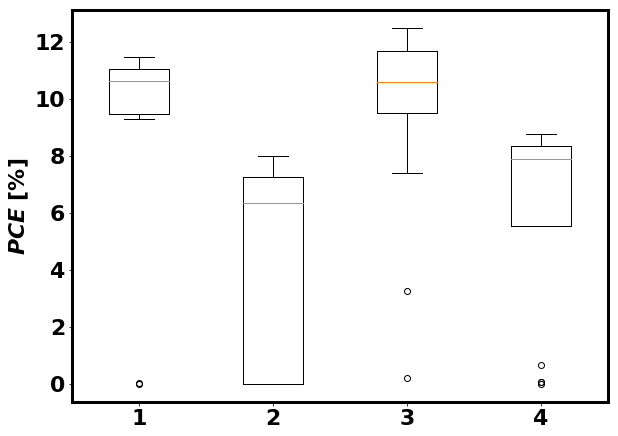

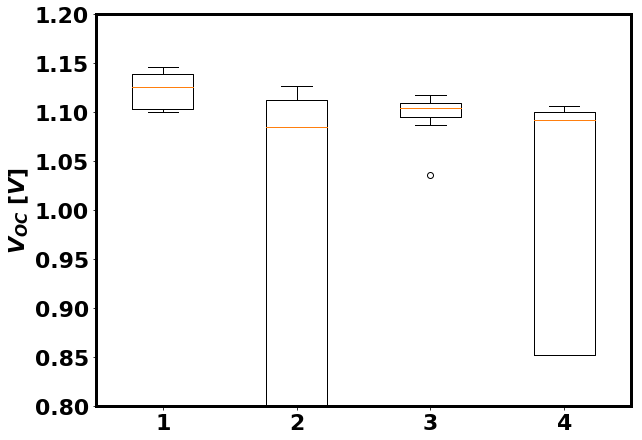

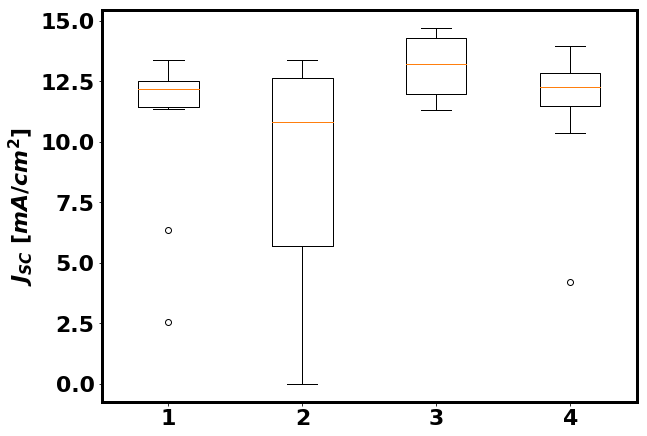

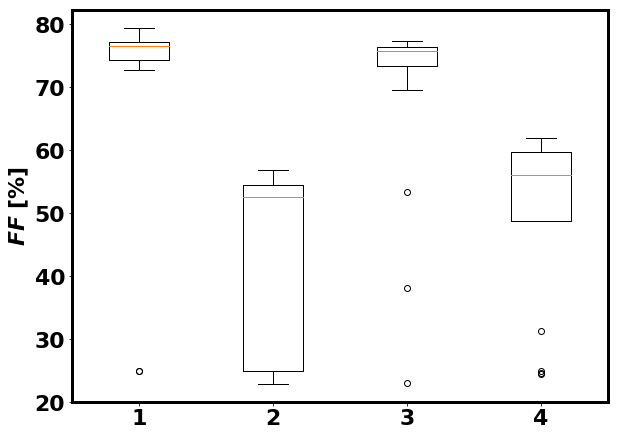

In [60]:
plt.boxplot(PCE_list);
plt.ylabel('$PCE\ [\%]$')
plt.figure()
plt.boxplot(Voc_list);
plt.ylabel('$V_{OC}\ [V]$')
plt.ylim(.8,1.2)
plt.figure()
plt.boxplot(Jsc_list);
plt.ylabel('$J_{SC}\ [mA/cm^2]$')
plt.figure()
plt.boxplot(FF_list);
plt.ylabel('$FF\ [\%]$')

In [53]:
Ldata

,0,1,2
0,Time (s):,J (mAcm^-2):,PCE (%):
1,0.000000000,0.000000159,0.000000135
2,0.984375000,0.000000324,0.000000275
3,1.982421875,0.000000299,0.000000254
4,2.986328125,0.000000316,0.000000269
5,3.986328125,0.000000299,0.000000254
6,4.985351562,0.000000307,0.000000261
7,5.984375000,0.000000298,0.000000254
8,6.988281250,0.000000311,0.000000265
9,7.985351562,0.000000322,0.000000274


In [51]:
LName

'Stoddard_2018_3-9JV_1_1_scan_0.png'

In [17]:
Jsc_list

[[14.569999999999995, 14.669999999999995, 14.230000000000008],
 [12.3, 12.830000000000014],
 [15.229999999999988,
  14.300000000000006,
  16.0,
  15.159999999999991,
  15.700000000000001,
  15.15],
 [12.239999999999997,
  11.639999999999995,
  12.490000000000002,
  12.419999999999998],
 [10.809999999999997,
  12.999999999999995,
  13.110000000000007,
  12.739999999999993],
 [15.082802547770703,
  13.321656050955411,
  13.961783439490436,
  14.850318471337582,
  15.363057324840785,
  15.038216560509557,
  14.388535031847127],
 [13.159235668789805,
  12.748407643312106,
  12.757961783439486,
  12.64012738853503,
  14.200636942675164,
  13.312101910828025,
  10.213375796178331,
  12.891719745222932],
 [14.222929936305734,
  14.035031847133752,
  13.691082802547772,
  13.949044585987266,
  14.108280254777073],
 [15.464968152866241,
  12.242038216560509,
  11.420382165605092,
  12.480891719745216,
  13.37261146496815,
  11.305732484076426,
  9.057324840764334,
  10.468152866242031,
  9.9968

In [49]:
LName = 'Stoddard_2018_3-9JV_1_1_scan_0.liv1'
LName[:22]

'Stoddard_2018_3-9JV_1_'